In [1]:
import fiona
import shapely
from shapely.geometry import *
import pandas as pd
import geopandas as gpd
import numpy as np

import descartes
import shapely.ops as ops

import matplotlib.pyplot as plt
%matplotlib inline

/Users/Ben/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [69]:
import sklearn
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
from math import radians, cos, sin, asin, sqrt

def haversine(p1, p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Points are ordered (lon, lat)
    """
    lon1, lat1 = p1[0], p1[1]
    lon2, lat2 = p2[0], p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def pt_to_tuple(pt):
    return (pt.xy[0][0], pt.xy[1][0])


def nearest_point(point, line):
    return line.interpolate(line.project(point))

In [4]:
home_sales = pd.read_csv("./major_road_data_science_challenge.csv")

In [5]:
home_sales.head()

,GeoLat,GeoLon,PostalCode,ClosePrice
0,33.869599,-111.842285,85262,1950000.0
1,33.593540,-111.827666,85259,1500000.0
2,33.519680,-111.982004,85018,1900000.0
3,33.659654,-111.871157,85255,2859000.0
4,33.564383,-112.249207,85345,165000.0


### Shape and geojson have coords flipped. Easier to flip the coordinates of the housing data points

### Longitude is x axis, Latitude is y axis

In [6]:
lon, lat = home_sales.GeoLon.tolist(), home_sales.GeoLat.tolist()
lon_lat_point = [shapely.geometry.Point(x, y) for x,y in zip(lon,lat)]

In [7]:
data_shp = gpd.read_file("./tl_2010_04_zcta510/tl_2010_04_zcta510.shp")

In [8]:
df_line = gpd.read_file("./phoenix_arizona.osm2pgsql-geojson/phoenix_arizona_osm_line.geojson")

In [28]:
data_shp.head(1)

,ALAND10,AWATER10,CLASSFP10,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MTFCC10,PARTFLG10,STATEFP10,ZCTA5CE10,geometry
0,440942496.0,212370.0,B5,S,0486506,+35.3580528,-109.2204013,G6350,N,04,86506,"POLYGON ((-109.283239 35.461549, -109.283268 3..."


### Focus on the highways


In [34]:
df_highways = df_line[df_line.highway == "motorway"].copy()

In [35]:
ls = [x for x in df_highways.ref.unique() if x!=None]
', '.join(ls)

u'I 8, I 10, AZ 85, AZ 303 Loop, AZ 303, Northern Parkway, AZ 101 Loop, AZ-101 Loop, I 17, I-17, I 17;US 60, AZ 202 Loop, AZ 51, I 10;US 60, AZ 202, AZ LOOP 202, AZ 202 Spur, AZ 143, US 60, AZ 24'

In [36]:
# data frame of highways
highways = df_highways.groupby("ref")["geometry"].apply(lambda x: ops.linemerge(x.values))

In [12]:
# dx = 0.05
# # bin_lon = np.arange(lon.min(), lon.max(), dx)
# bin_lon = np.linspace(xedges[0], xedges[-1], 100)
# lon_group = pd.cut(lon, bin_lon, labels=bin_lon[:-1])

# # bin_lat = np.arange(lat.min(), lat.max(), dx)
# bin_lat = np.linspace(yedges[0], yedges[-1], 100)
# lat_group = pd.cut(lat, bin_lat, labels=bin_lat[:-1])

# home_sales["LatGroup"] = lat_group
# home_sales["LonGroup"] = lon_group

# # ax.set_xlim(-113, -111.4)
# # ax.set_ylim(32.5, 34.3)

In [13]:
# data = home_sales.groupby(["LatGroup", "LonGroup"])["ClosePrice"].agg({"Mean":np.mean, 
#                                                                       "Size":np.count_nonzero})
# data = data[data.Size >= 10]
# # data.sort_values("Mean", ascending=False)

# grid = data.Mean.unstack("LonGroup").sort_index().sort_index(axis=1)

In [38]:
bins = 500
weights = home_sales.ClosePrice.tolist()

H_total, xedges, yedges = np.histogram2d(lon, lat, weights=weights, bins=bins)

H_count, xedges, yedges = np.histogram2d(lon, lat, bins=bins)

# keep only high counters
H_total[H_count <= 10] = 0

H_mean = H_total/H_count
H_mean = np.nan_to_num(H_mean)

In [39]:
ss = pd.DataFrame(H_count.ravel(), columns=["Count"])
ss["Sum"] = H_total.ravel()
ss["Mean"] = ss.Sum/ss.Count
ss[ss.Count > 0].sort_values("Mean", ascending=False)
ss.head()

,Count,Sum,Mean
0,0.0,0.0,NaN
1,0.0,0.0,NaN
2,0.0,0.0,NaN
3,0.0,0.0,NaN
4,0.0,0.0,NaN


scale is 1.46118782366 km per bin


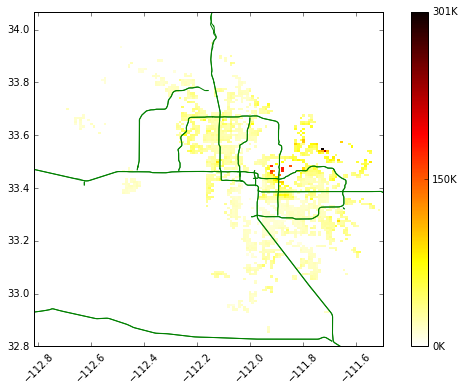

In [56]:
fig,ax = plt.subplots(figsize=(10,6))

# the heat map
cax = ax.imshow(H_mean, interpolation='nearest', origin='low', cmap='hot_r',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

m,M = np.min(H_mean), np.max(H_mean)
mid = m/2+M/2
cbar = fig.colorbar(cax, ticks=[m, mid, M])
cbar.ax.set_yticklabels(["{0:.0f}K".format(x/10e3) for x in [m,mid,M]])


# the roads
for highway in highways:
    try:
        for line in highway.geoms:
            ax.plot(*line.xy, color='green')
    except:
        pass
#         print type(highway)


# boundary
lines = ops.linemerge(df_highways.geometry.values)
xmin, ymin, xmax, ymax = lines.bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# scale
p = np.array([xmin, ymin])
l1 = xedges[1] - xedges[0]
l2 = yedges[1] - yedges[0]
d = np.linalg.norm([l1,l2])

print "scale is %s km per bin" %haversine(p, p + np.array([0, d])) 

plt.xticks(rotation=45)

plt.savefig("HeatMap.png", dpi=1000)

### Find distances to different roads
Need to use haversine formula - euclidean distance can't be easily transformed to true distance - varies a lot depending on bearing

### Nearest point on each highway

In [90]:
# find the distance to each distinct highway
# def distance_to_highways(point):
#     return highways.map(lambda x: nearest_point(point, x))

# ls = [distance_to_highways(pt) for pt in lon_lat_point]
# pt_on_highways = pd.concat(ls, axis=1).T.reset_index(drop=True)
# pt_on_highways.to_csv("pt_on_highways.csv", index=False)

In [58]:
%%time
import re
def string_to_point(s):
    match = re.search(r"(?:\()([^\)]+)(?:\))", s).groups()[0].split(" ")
    return  Point([float(x) for x in match])

df = pd.read_csv("pt_on_highways.csv")
pt_on_highways = df.applymap(string_to_point)

CPU times: user 21.8 s, sys: 420 ms, total: 22.3 s
Wall time: 22.3 s


### Haversine distance to each highway

In [504]:
# %%time
# def shapely_haversine(pt1, pt2):
#     return haversine(pt_to_tuple(pt1), pt_to_tuple(pt2))

# distance_to_highways = pd.DataFrame(columns=pt_on_highways.columns)
# for col in distance_to_highways.columns:
#     hwy = pt_on_highways[col].tolist()
#     ls = [shapely_haversine(p1, p2) for p1,p2 in zip(lon_lat_point, hwy)]
#     distance_to_highways[col] = ls
    
# distance_to_highways.to_csv("DistanceToHighways.csv", index=False)

CPU times: user 1min 14s, sys: 311 ms, total: 1min 15s
Wall time: 1min 16s


In [60]:
distance_to_highways = pd.read_csv("DistanceToHighways.csv")

In [61]:
# min distance to any highway
distance_to_highway = distance_to_highways.min(axis=1)

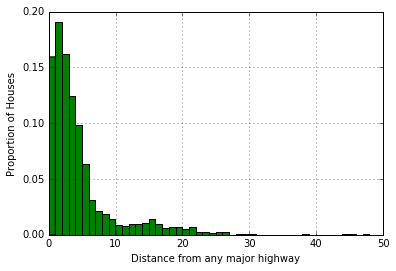

In [62]:
mask = distance_to_highway < 50
ax = distance_to_highway[mask].hist(bins=50, normed=True, color = "green")
distance_to_highway.describe()

ax.set_xlabel("Distance from any major highway")
ax.set_ylabel("Proportion of Houses")
plt.savefig("Histogram.png", dpi=100)

In [63]:
distance_to_highway.describe().to_frame()

,0
count,57788.000000
mean,6.894960
std,16.520925
min,0.002603
25%,1.490691
50%,2.998007
75%,5.451366
max,244.090420


In [64]:
# proportion that live less than 1 km away
(distance_to_highway <= 1).mean()

0.15532636533536373

In [65]:
# 85% of people live within 10km of highway
distance_to_highway.quantile(0.85)

9.1646061564649735

### Median housing price as a function of distance grouped in bins 

In [415]:
max_distance = 15
dx = 0.1
bins = np.arange(0, max_distance, dx)

In [430]:
data = home_sales.ClosePrice.to_frame()
data["Distance"] = pd.cut(distance_to_highway, bins, labels=bins[:-1])
data = data.groupby("Distance")["ClosePrice"].apply(lambda x: np.log10(x).median()).reset_index()

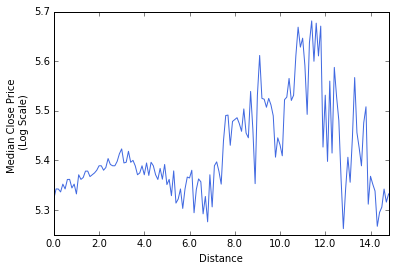

In [431]:
# data_plot = data.copy()
# data_plot["ClosePrice"] = np.log10(data_plot.ClosePrice)

ax = data.set_index("Distance").plot(color='royalblue')
ax.legend().set_visible(False)
ax.set_ylabel("Median Close Price \n (Log Scale)")
plt.savefig("PriceVDistance.png", dpi=100)

### Model fit to housing price as function of distance

In [432]:
mask = distance_to_highway < max_distance
X, y = distance_to_highway[mask].values.reshape(-1,1), np.log10(home_sales[mask].ClosePrice)

In [452]:
deg = 3
model = make_pipeline(PolynomialFeatures(degree=deg), RidgeCV(fit_intercept=False))
model.fit(X,y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridgecv', RidgeCV(alphas=array([  0.1,   1. ,  10. ]), cv=None, fit_intercept=False,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False))])

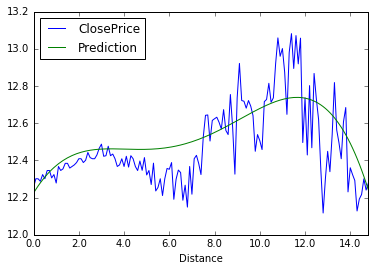

In [426]:
x = np.array(bins[:-1]).reshape(-1,1)
data_plot = data.copy()
data_plot.ClosePrice = np.log(data_plot.ClosePrice)
data_plot["Prediction"] = model.predict(x)

data_plot.set_index("Distance").plot()

ax.set_ylabel("Median Close Price \n (Log Scale)")
plt.savefig("PriceVDistance_Model.png", dpi=100)

In [453]:
#how well does the model do 
y_predict = 10**model.predict(X)
y_true = 10**y

print "Mean Absolute Error: %s" %sklearn.metrics.mean_absolute_error(y_true, y_predict)
print "Median Proportion of Error: %s" %np.median(np.abs(y_true - y_predict)/y_true)
print "R2 score: %s" %sklearn.metrics.r2_score(y_true, y_predict)

Mean Absolute Error: 121703.778337
Median Proportion of Error: 0.308043982881
R2 score: -0.0142369783404


In [454]:
# how well does the base median model do 
y_median = [(10**y).median()]*len(y)
y_true = 10**y

print "Mean Absolute Error: %s" %sklearn.metrics.mean_absolute_error(y_true, y_median)
print "Median Proportion of Error: %s" %np.median(np.abs(y_true - y_median)/y_true)
print "R2 score: %s" %sklearn.metrics.r2_score(y_true, y_median)

Mean Absolute Error: 121676.276576
Median Proportion of Error: 0.300546448087
R2 score: -0.0518506305511


### Distance from multiple highways

In [158]:
n = 2

max_distance = 20
dx = 0.1
bins = np.arange(0,max_distance, dx)
data = home_sales.ClosePrice.to_frame()

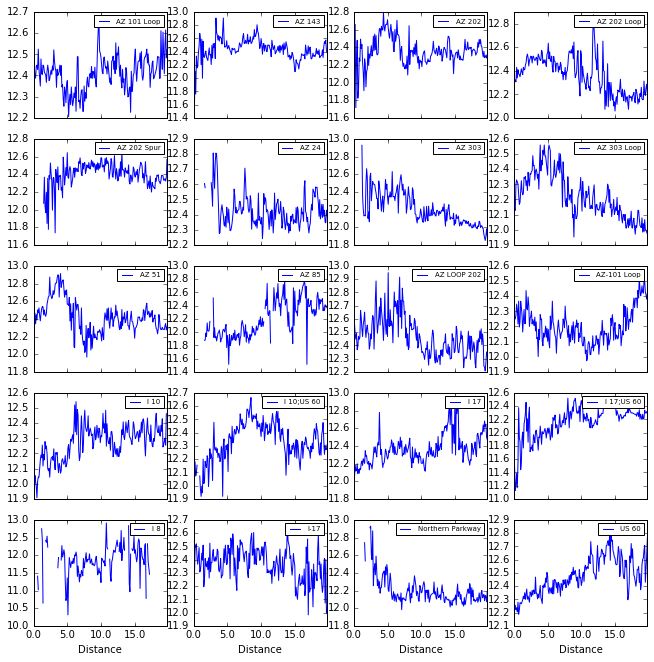

In [187]:
fig, ax = plt.subplots(5,4, figsize=(11,11), sharex=True)

for a,col in zip(ax.ravel(), distance_to_highways.columns): 

    data["Distance"] = pd.cut(distance_to_highways[col], bins, labels=bins[:-1])
    
    data_plot = data.groupby("Distance")["ClosePrice"].apply(lambda x: np.log(x).median())
    
    data_plot.plot(ax=a, label=col)
    a.legend(fontsize=7)
#     a.set_xlim(12,13)

Build model based on all distances

In [84]:
from sklearn.linear_model import RidgeCV
model = RidgeCV()
X,y = distance_to_highways, np.log10(home_sales.ClosePrice)

In [85]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
X,y, test_size=0.3, random_state=42)

In [86]:
model.fit(X_train,y_train)

RidgeCV(alphas=array([  0.1,   1. ,  10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [87]:
#how well does the model do 
y_predict = 10**model.predict(X_test)
y_true = 10**y_test

print "Mean Absolute Error: %s" %sklearn.metrics.mean_absolute_error(y_true, y_predict)
print "Median Proportion of Error: %s" %np.median(np.abs(y_true - y_predict)/y_true)
print "R2 score: %s" %sklearn.metrics.r2_score(y_true, y_predict)

Mean Absolute Error: 97713.6504687
Median Proportion of Error: 0.236983694086
R2 score: 0.253838798583


In [89]:
scores = pd.DataFrame()
scores["Values"] = model.coef_
scores["Coeff"] = X.columns

In [92]:
scores.sort_values("Values", ascending=False)

,Values,Coeff
13,0.062627,I 10;US 60
15,0.015431,I 17;US 60
19,0.013248,US 60
16,0.008237,I 8
14,0.006015,I 17
18,0.005356,Northern Parkway
0,0.003260,AZ 101 Loop
11,0.002382,AZ-101 Loop
8,0.002261,AZ 51
9,0.001570,AZ 85


### Primary or residential roads

In [55]:
residential = df_line[df_line.highway == "residential"]

In [217]:
df_line.name = df_line.name.fillna("Missing")
road_names = df_line[df_line.name.str.contains("North Cave Creek Road")]

In [362]:
residential.name.head()

13           Missing
14           Missing
18    Camelback Road
22           Missing
25           Missing
Name: name, dtype: object